In [19]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time
import zipfile
from IPython import display
import os
import cv2
from matplotlib import image
from skimage.color import rgb2gray

In [20]:
#### HYPER PARAMETERS
BATCH_SIZE = 50
EPOCHS = 50
noise_dim = 100
BUFFER_SIZE = 60000
WIDTH=128
HEIGHT=128

# Name of dataset zip file without .zip extension
Dataset = "CT_COVID"

# to visualize progress in the animated GIF)
seed = tf.random.normal([1, noise_dim])

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
filepath = "/content/drive/My Drive/Colab Notebooks/COVID19-GAN"
os.system("mkdir -p \"/content/drive/My Drive/Colab Notebooks/COVID_GAN_Saved_Models\"")
destination = "/drive/Data"
save_destination = "/content/drive/My Drive/Colab Notebooks/COVID_GAN_Saved_Models"

# Will unzip the files so that you can see them..
print(filepath)
with zipfile.ZipFile(filepath+"/"+Dataset+".zip","r") as z:
    z.extractall(destination)

/content/drive/My Drive/Colab Notebooks/COVID19-GAN


In [23]:
os.chdir(destination + "/" + Dataset)

path = "*.*"
data = []
for file in glob.glob(path):
  if(file.find("image_at_epoch") == -1):
    img_data = image.imread(file, 0)
    data.append(img_data)  
data = np.array(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [24]:
standardized_data = []
for img in data:
  img = rgb2gray(img)
  img2 = np.flip(img, axis=1) ## ADD FLIPPED IMAGE FOR LARGER DATA SET
  standardized_data.append(cv2.resize(img, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC).astype('float32'))
  standardized_data.append(cv2.resize(img2, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC).astype('float32'))
train_images = np.array(standardized_data)
train_images = train_images.reshape(train_images.shape[0], 128,128,1).astype('float32')
print(train_images.shape)

(698, 128, 128, 1)


0

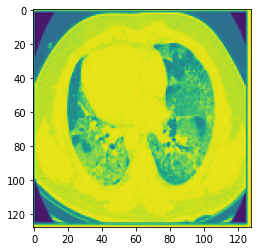

In [25]:
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
checker = train_images # np.reshape(train_images, (2164,28,28))
plt.imshow(checker[5,:,:,0])

os.system("rm -r \""+destination+"\"")

In [26]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 1)

    model.add(layers.Flatten())
    model.add(layers.Dense(128*128, use_bias=False, activation = 'tanh'))
    model.add(layers.Reshape((128,128,1)))
    print(model.output_shape)

    return model

In [27]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 4, 4, 1024)
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64))
    model.add(layers.Dense(32))
    model.add(layers.Dense(16))
    model.add(layers.Dense(1, activation="sigmoid"))

    opt = tf.keras.optimizers.Adam(1e-4)
    model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [28]:
def make_gan(g_model, d_model):
  d_model.trainable = False
  model = tf.keras.Sequential()
  model.add(g_model)
  model.add(d_model)

  opt = tf.keras.optimizers.Adam(1e-4)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [29]:
def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = np.ones((n_samples, 1))
  return X,y

In [30]:
def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim*n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [31]:
def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  X = g_model.predict(x_input)
  y = np.zeros((n_samples, 1))
  return X,y

In [32]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size):
  genLoss = 0
  discLoss = 0
  batch_per_epoch = int(dataset.shape[0]/batch_size)
  half_batch = int(batch_size/2)
  best_g_model = g_model
  best_genLoss = 10
  for epoch in range(n_epochs):
    start = time.time()
    for i in range(batch_per_epoch):
      X_real, y_real = generate_real_samples(dataset,half_batch)
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)

      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

      discLoss = (d_loss1 + d_loss2)/2

      X_gan = generate_latent_points(latent_dim, batch_size)
      y_gan = np.ones((batch_size, 1))
      genLoss = gan_model.train_on_batch(X_gan, y_gan)
  
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(g_model,
                             epoch + 1,
                             seed)
    
    ### PERFORMANCE CHECK
    X_real, y_real = generate_real_samples(dataset, 100)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, 100)
    _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
    print("Disc Accuracy Real: %.5f, fake: %.5f" % (acc_real, acc_fake))
    print("genloss: {} discloss: {}".format(genLoss, discLoss))
    if (epoch > 2./3. * n_epochs):
      if (genLoss < best_genLoss and acc_real > 0.9 and acc_fake > 0.9):
        best_genLoss = genLoss
        best_g_model = g_model

    # Save the model every 100 epochs
    if epoch%100 == 0:
      g_model.save(save_destination+"/generator_intermediate.h5")
      d_model.save(save_destination+"/discriminator_intermediate.h5")

    genloss.append(genLoss)
    discloss.append(discLoss)
    accReal.append(acc_real)
    accFake.append(acc_fake)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(g_model,
                           n_epochs,
                           seed)
  print("Training complete")
  return best_g_model

In [33]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.show()

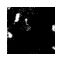

Training complete


In [34]:
genloss = []
discloss = []
accReal = []
accFake = []
d_model = make_discriminator_model()
g_model = make_generator_model()
gan_model = make_gan(g_model, d_model)
generator = train(g_model, d_model, gan_model, train_images, noise_dim, EPOCHS, BATCH_SIZE)

g_model.save(save_destination+"/generator_final.h5")
d_model.save(save_destination+"/discriminator_final.h5")
gan_model.save(save_destination+"/gan_final.h5")

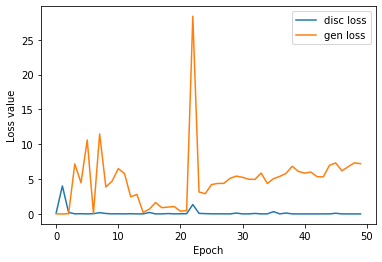

In [43]:
plt.plot(range(EPOCHS), discloss, label='disc loss')
plt.plot(range(EPOCHS), genloss, label='gen loss')
plt.xlabel('Epoch')
# plt.ylim(-1,20)
plt.ylabel('Loss value') 
plt.legend()
plt.show()

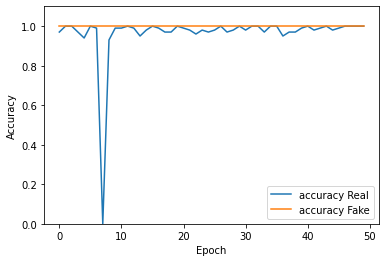

In [42]:
plt.plot(range(EPOCHS), accReal, label='accuracy Real')
plt.plot(range(EPOCHS), accFake, label='accuracy Fake')
plt.xlabel('Epoch')
plt.ylim(0,1.1)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

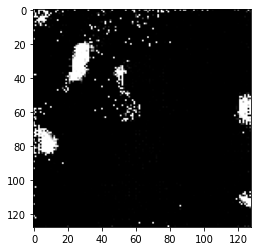

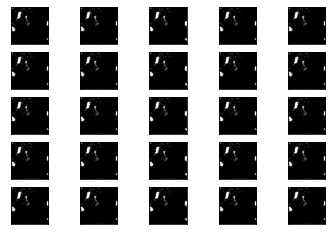

In [37]:
plt.figure()
noise = np.random.randn(noise_dim)
noise = noise.reshape(1, noise_dim)
generated_image0 = generator.predict(noise)
plt.imshow(generated_image0[0, :, :, 0], cmap='gray')

f = plt.figure()
for i in range(1,26):
  f.add_subplot(5,5, i)
  noise = np.random.randn(noise_dim)
  noise = noise.reshape(1, noise_dim)
  generated_image0 = generator.predict(noise)
  plt.imshow(generated_image0[0, :, :, 0], cmap='gray')
  plt.xticks([])
  plt.yticks([])
plt.show()